In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random

import gym
from gym import spaces
import keras
from keras.layers import *
from keras.models import Model
import numpy
import rl
import scipy.sparse
import skimage.io

%matplotlib inline

/home/santiago/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [149]:
class SNN(gym.Env):
    
    def __init__(self, specification):
        self.specification = specification
#         self.action_space = gym.spaces.Box(-1, 1, (self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons']))
        self.action_space = gym.spaces.Discrete(3)
#         self.observation_space = gym.spaces.Box(-1, 1, (self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['max_history'], self.specification['input_neurons'] + self.specification['inter_neurons'] + 2))
        self.observation_space = gym.spaces.Box(-1, 1, (self.specification['max_history'], 4))
        self.potential_matrix = numpy.zeros((self.specification['input_neurons'] + self.specification['inter_neurons'] + self.specification['output_neurons'],))
        self.weight_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons']))
        self.weight_mask = numpy.ones_like(self.weight_matrix, dtype=numpy.uint8)
        self.weight_mask[-self.specification['output_neurons']:, :self.specification['input_neurons']] = 0
        numpy.fill_diagonal(self.weight_mask[:self.specification['inter_neurons'], -self.specification['inter_neurons']:], 0)
#         self.history_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['max_history'], self.specification['input_neurons'] + self.specification['inter_neurons'] + 2))
        self.history_matrix = numpy.zeros((self.specification['inter_neurons'] + self.specification['output_neurons'], self.specification['input_neurons'] + self.specification['inter_neurons'], self.specification['max_history'], 4))
        self.neuron_idx = 0
        self.weight_idx = 0
        self.random_seed = None
        self.next_input = None
        self.previous_reward = None
    
    def interconnect(self, weight_density):
        sparse_matrix = scipy.sparse.random(self.weight_matrix.shape[0], self.weight_matrix.shape[1], density=weight_density, random_state=self.random_seed)
        sparse_matrix.data *= 2
        sparse_matrix.data -= 1
        self.weight_matrix = numpy.multiply(sparse_matrix.toarray(), self.weight_mask)
    
    def load_weights(self, weights):
        pass
    
    def close(self):
        self.specification['environment'].close()
        
    def reset(self):
        self.next_input = self.specification['environment'].reset()
#         self.neuron_idx = 0
#         self.weight_idx = 0
        self.previous_reward = None
        self.potential_matrix[:] = 0
        if self.specification['neuroplasticity']:
            self.history_matrix[:, :, :] = 0
        return self.history_matrix[self.neuron_idx, self.weight_idx, :, :]
    
    def render(self, mode='human'):
        return self.specification['environment'].render(mode)
    
    def seed(self, seed):
        self.random_seed = seed
        return self.specification['environment'].seed(self.random_seed)
    
    def step(self, action):
        actions = numpy.full_like(self.weight_matrix, action - 1)
#         self.neuron_idx += 1
#         self.weight_idx += 1
#         if self.neuron_idx == self.weight_matrix.shape[0]:
#             self.neuron_idx = 0
#         if self.weight_idx == self.weight_matrix.shape[1]:
#             self.weight_idx = 0
#         print(action)
#         print(self.neuron_idx, self.weight_idx)
        if self.specification['neuroplasticity']:
            self.weight_matrix = numpy.clip(numpy.multiply(numpy.add(self.weight_matrix, self.specification['learning_rate'] * actions), self.weight_mask), -1, 1)
#             self.weight_matrix[self.neuron_idx, self.weight_idx] += self.specification['learning_rate'] * (action - 1)
#             self.weight_matrix = numpy.clip(numpy.multiply(self.weight_matrix, self.weight_mask), -1, 1)
#         state = numpy.zeros_like(self.history_matrix[self.neuron_idx, self.weight_idx, :, :])
#         reward = 0
#         terminal = False
#         if self.neuron_idx == 0 and self.weight_idx == 0:
        self.potential_matrix[:self.specification['input_neurons']] = numpy.add(self.potential_matrix[:self.specification['input_neurons']], self.next_input)
        firing_matrix = numpy.vectorize(lambda x: x >= 1)(self.potential_matrix)
        for i in range(self.specification['inter_neurons'] + self.specification['output_neurons']):
            pos = self.specification['input_neurons'] + i
            deltas = numpy.multiply(firing_matrix[:-self.specification['output_neurons']], self.weight_matrix[i])
            delta = numpy.sum(deltas)
            if self.specification['neuroplasticity']:
                self.history_matrix[i, self.weight_idx, self.specification['max_history'] - 1, :] = numpy.array([deltas[self.weight_idx], delta, self.potential_matrix[pos], firing_matrix[pos]])
            self.potential_matrix[pos] += delta
        self.potential_matrix = numpy.clip(numpy.multiply(self.potential_matrix, numpy.invert(firing_matrix)), -1, 1)
        if self.specification['neuroplasticity']:
            self.history_matrix = numpy.roll(self.history_matrix, 2, axis=1)
        state = self.history_matrix[self.neuron_idx, self.weight_idx, :, :]
        self.next_input, reward, terminal, info = self.specification['environment'].step(firing_matrix[-self.specification['output_neurons']:].astype(int))
#             reward = 0 if self.previous_reward is None else current_reward - self.previous_reward
#             self.previous_reward = current_reward
#         if self.weight_idx == self.specification['input_neurons'] + self.specification['inter_neurons'] - 1:
#             self.weight_idx = 0
#             if self.neuron_idx == self.specification['inter_neurons'] + self.specification['output_neurons'] - 1:
#                 self.neuron_idx = 0
#             else:
# #                 print(self.neuron_idx)
#                 self.neuron_idx += 1
#         else:
#             self.weight_idx += 1
        return state, reward, terminal, info

In [150]:
input_neurons = 8
inter_neurons = 128
output_neurons = 8
max_history = 16
hidden_size = 32

In [160]:
class Test2(gym.Env):
    
    def __init__(self):
        self.action_space = gym.spaces.Box(0, 1, (1,))
        self.observation_space = gym.spaces.Box(0, 1, (1,))
        self.state = None
        self.idx = None
        self.random_seed = None
        self.previous_action = None
    
    def seed(self, seed):
        self.random_seed = seed
        random.seed(seed)
        return seed
    
    def close(self):
        pass
    
    def reset(self):
        self.state = numpy.ones((1,))
        self.idx = 0
        self.previous_action = 0
        return self.state
    
    def step(self, action):
#         print(action)
#         print(self.idx)
#         self.state[action] = int(not bool(self.state[action]))
#         self.state = numpy.zeros((16,))
#         self.state[self.idx] = 1
        self.idx += 1
        terminal = self.idx == 100
        reward = 0.0
#         if action[0] == 0 and self.previous_action == 0:
#             reward = 1.0
#         else:
#             reward = -1000
        if action[0] == 1:
            reward = 1.0
        elif self.previous_action == 0:
            reward = 0.0
        self.previous_action = action[0]
        return self.state, reward, terminal, {}

In [161]:
import numpy
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory


ENV_NAME = 'SNN'


# Get the environment and extract the number of actions.
#env = gym.make(ENV_NAME)
env = SNN({'environment': Test2(), 'input_neurons': 1, 'inter_neurons': 64, 'output_neurons': 1, 'max_history': 16, 'neuroplasticity': True, 'learning_rate': 0.01})
numpy.random.seed(0)
env.seed(0)
env.interconnect(0.1)
nb_actions = env.action_space.n
#functools.reduce(operator.mul, env.action_space.shape)

/home/santiago/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


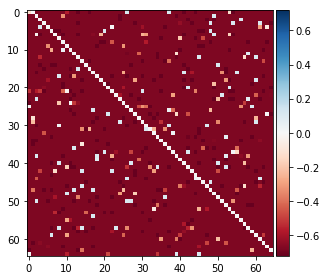

In [164]:
skimage.io.imshow(env.weight_matrix)

In [163]:
# Next, we build a very simple model.
# model = Sequential()
# model.add(Reshape((16, 4), input_shape=(1, 16, 4)))
# model.add(Bidirectional(LSTM(32, return_sequences=True), merge_mode='concat'))
# model.add(Dropout(0.25))
# model.add(Bidirectional(LSTM(32), merge_mode='concat'))
# model.add(Dropout(0.25))
# model.add(Dense(3, activation='linear'))
# print(model.summary())
model = Sequential()
model.add(Reshape((64,), input_shape=(1, 16, 4)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy(0.99)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_36 (Reshape)         (None, 64)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_142 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_143 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_144 (Dense)            (None, 3)                 51        
Total params: 6,819
Trainable params: 6,819
Non-trainable params: 0
_________________________________________________________________
None
Training for 50000 steps ...
   100/50000: episode: 1, duration: 0.677s, episode steps: 100, steps per second: 148, episode reward: 26.

  2700/50000: episode: 27, duration: 0.742s, episode steps: 100, steps per second: 135, episode reward: 0.000, mean reward: 0.000 [0.000, 0.000], mean action: 0.970 [0.000, 2.000], mean observation: -0.004 [-1.000, 0.146], loss: 0.158694, mean_absolute_error: 2.522339, mean_q: 3.671645
  2800/50000: episode: 28, duration: 0.745s, episode steps: 100, steps per second: 134, episode reward: 0.000, mean reward: 0.000 [0.000, 0.000], mean action: 0.760 [0.000, 2.000], mean observation: -0.003 [-1.000, 0.166], loss: 0.192029, mean_absolute_error: 2.572355, mean_q: 3.742008
  2900/50000: episode: 29, duration: 0.744s, episode steps: 100, steps per second: 134, episode reward: 0.000, mean reward: 0.000 [0.000, 0.000], mean action: 0.900 [0.000, 2.000], mean observation: -0.009 [-1.000, 0.000], loss: 0.228845, mean_absolute_error: 2.590037, mean_q: 3.797327
  3000/50000: episode: 30, duration: 0.722s, episode steps: 100, steps per second: 138, episode reward: 0.000, mean reward: 0.000 [0.000, 0